In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import StepLR
import os
import matplotlib.pyplot as plt

In [2]:
lambda_data = '/mnt/d/Users/Admin/Projects/Machine_Learning/data'
delta_data = '/workspace/alvin/Machine_Learning_Studying/data'
data_lst = [lambda_data, delta_data]
data_pth = data_lst[0]

In [3]:
data_transforms = {
    "train" : transforms.Compose([
        transforms.Resize(size = (224, 224)), # resize to 224 by 224 for resnet
        # transforms.CenterCrop(size = (224, 224)),
        transforms.Grayscale(num_output_channels = 3), # this converts grayscale to rgb channels
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    "test" : transforms.Compose([
        transforms.Resize(size = (224, 224)), # resize to 224 by 224 for resnet
        # transforms.CenterCrop(size = (224, 224)),
        transforms.Grayscale(num_output_channels = 3), # this converts grayscale to rgb channels
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
}

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [5]:
training_data = datasets.FashionMNIST(
    root = data_pth,
    train = True,
    download = True,
    transform = data_transforms["train"]
)

train_ds, val_ds = random_split(training_data, [50_000, 10_000])

ds_dict = {"train" : train_ds, "val" : val_ds}
dataset_sizes = {"train" : len(train_ds), "val" : len(val_ds)}

In [6]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /workspace/alvin/Machine_Learning_Studying/data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
dataloaders = {x : DataLoader(ds_dict[x], batch_size = 2**7, num_workers = 4, shuffle = True) for x in ds_dict.keys()}

In [8]:
# load pre-trained model
model = models.resnet18(weights = "DEFAULT")

# Freeze all layers except final layer
# final layer is responsible for classification
for name, param in model.named_parameters():
    if "fc" in name:
        # unfreeze the fc layers
        # this means we are only training the fc layers
        param.requires_grad = True 
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # most common used nn for classification problems
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# scheduler = StepLR(optimizer, step_size = 5, gamma = 0.1) # this reduces lr every 4 epoch by 0.1

# move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
# Training loops
num_epochs = 50
for epoch in range(num_epochs):
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0 # correct predictions

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # clear the gradient from previous iteration

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels) # check if output and labels match

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # scheduler.step()
    # print(f"Epoch {epoch+1} LR: {scheduler.get_last_lr()[0]:.10f}")

print("Training complete!")

train Loss: 1.0333 Acc: 0.6778
val Loss: 0.5993 Acc: 0.7914
train Loss: 0.5537 Acc: 0.8104
val Loss: 0.5021 Acc: 0.8243
train Loss: 0.4962 Acc: 0.8285
val Loss: 0.4678 Acc: 0.8349
train Loss: 0.4657 Acc: 0.8369
val Loss: 0.4399 Acc: 0.8448
train Loss: 0.4464 Acc: 0.8420
val Loss: 0.4290 Acc: 0.8491
train Loss: 0.4325 Acc: 0.8464
val Loss: 0.4178 Acc: 0.8507
train Loss: 0.4204 Acc: 0.8524
val Loss: 0.4088 Acc: 0.8560
train Loss: 0.4124 Acc: 0.8542
val Loss: 0.4125 Acc: 0.8543
train Loss: 0.4053 Acc: 0.8554
val Loss: 0.3992 Acc: 0.8590
train Loss: 0.4012 Acc: 0.8576
val Loss: 0.3936 Acc: 0.8598
train Loss: 0.3941 Acc: 0.8608
val Loss: 0.3918 Acc: 0.8597
train Loss: 0.3910 Acc: 0.8610
val Loss: 0.3928 Acc: 0.8599
train Loss: 0.3867 Acc: 0.8614
val Loss: 0.3918 Acc: 0.8591
train Loss: 0.3844 Acc: 0.8629
val Loss: 0.3813 Acc: 0.8635
train Loss: 0.3817 Acc: 0.8642
val Loss: 0.3798 Acc: 0.8654
train Loss: 0.3784 Acc: 0.8652
val Loss: 0.3807 Acc: 0.8641
train Loss: 0.3746 Acc: 0.8669
val Loss:

In [10]:
# Save model
torch.save(model.state_dict(), "/workspace/alvin/weights/fashionmnist_epoch_50_resnet18.pth")

## Classification on Test data

In [15]:
model = models.resnet18(weights = "DEFAULT")
model.fc = nn.Linear(model.fc.in_features, 1000) # was trained on ImageNet, there are 1000 classes
model.load_state_dict(torch.load("/workspace/alvin/weights/fashionmnist_epoch_50_resnet18.pth"))
model = model.to(device)
model.eval()

new_model = models.resnet18(weights = "DEFAULT")
new_model.fc = nn.Linear(model.fc.in_features, len(labels_map))

new_model.fc.weight.data = model.fc.weight.data[0: len(labels_map)]
new_model.fc.bias.data = model.fc.bias.data[0:len(labels_map)]
new_model = new_model.to(device)  # move the model to GPU
new_model.eval() # 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
test_data = datasets.FashionMNIST(
    root = data_pth,
    train = False,
    download = True,
    transform = data_transforms["test"]
)

test_loader = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = False
)

In [16]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8692


image 1 
 Pred: Ankle Boot, True: Ankle Boot


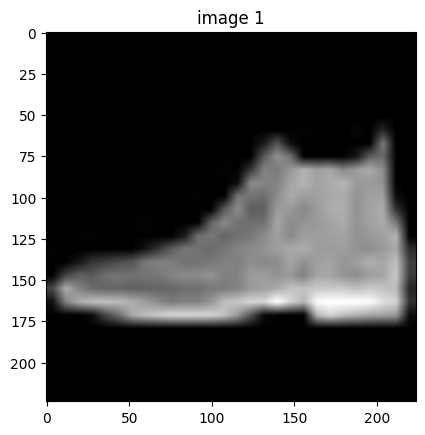

image 2 
 Pred: Pullover, True: Pullover


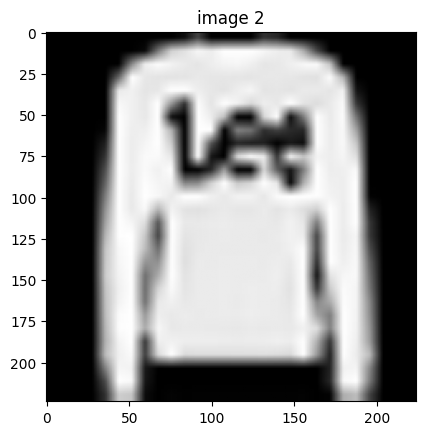

image 3 
 Pred: Trouser, True: Trouser


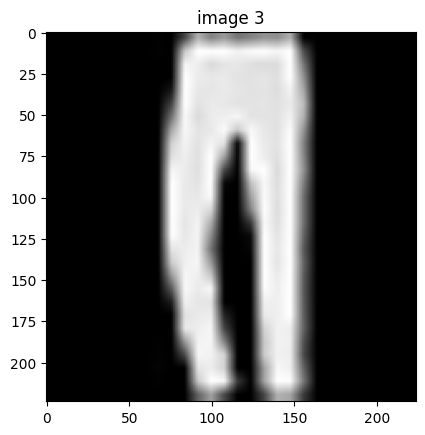

image 4 
 Pred: Trouser, True: Trouser


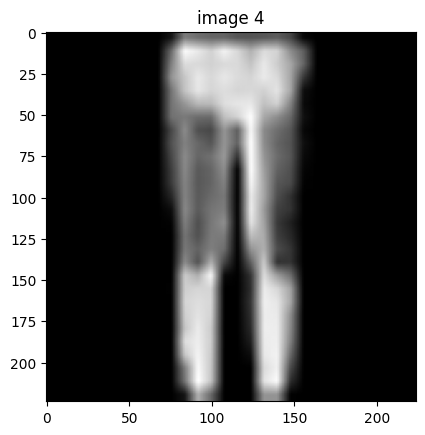

image 5 
 Pred: Shirt, True: Shirt


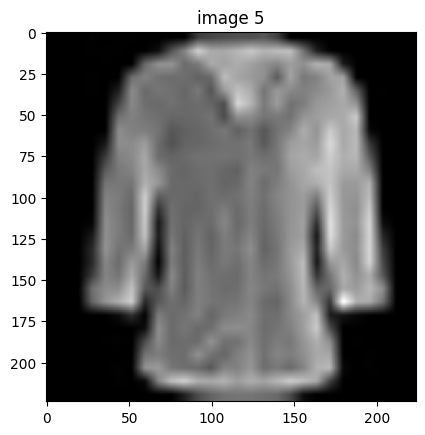

image 6 
 Pred: Trouser, True: Trouser


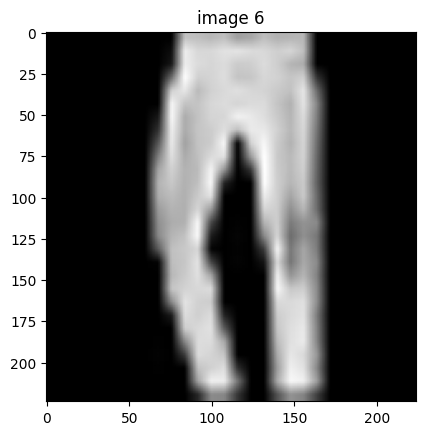

In [17]:
for i in range(6):
    image, label = test_data[i]
    image_batch = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_batch)
        _, preds = torch.max(outputs, 1)

    pred_class = preds.item()
    
    plt.imshow(image[0].squeeze(), cmap = "gray")
    plt.title(f"image {i+1}")
    print(f"image {i+1} \n Pred: {labels_map[pred_class]}, True: {labels_map[label]}")
    plt.show()